In [1]:
import os
import time
import pickle
import glob
import warnings
import numpy as np
import astropy.io.fits as fits
import pyklip.fitpsf as fitpsf
import matplotlib.pylab as plt
import pyklip.instruments.MagAO as MagAO
from pyklip.klip import nan_gaussian_filter
from forwardModel import forwardModel
import GhostIsolation as ghost
import multiprocessing as mp

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import seaborn as sns
plt.rcParams['font.family'] = 'monospace'   # Fonts
plt.rcParams['font.monospace'] = 'DejaVu Sans Mono'
sns.set_context("talk")

In [4]:
import pymultinest

In [5]:
# plotting functions
def create_circular_mask(h, w, center=None, radius=None, leq=False):

    if center is None:  # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None:  # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    if leq is False:
        return dist_from_center >= radius
    else:
        return dist_from_center <= radius


def domask(img, inn=70, outt=180):
    outermask = create_circular_mask(img.shape[0], img.shape[1], radius=outt, leq=True)
    img[~outermask] = np.nanmedian(img)
    mask = create_circular_mask(img.shape[0], img.shape[1], radius=inn)
    masked_img = img.copy()
    masked_img[~mask] = np.nanmedian(img)
    return masked_img

In [6]:
platescale=7.95
platescale_err=0.10
pa_offset=-0.497
pa_uncertainty=0.192

In [7]:
# loop inputs
date = 'HD100453/3May18'  # str(input('enter date in format ##Month##: '))
sep = 131 # int(input('enter sep: '))
pa = 133.5  # int(input('enter pa: '))

In [33]:
# this is just a block where I fiddle with the numbers to determine what the ann1 and ann2 params should be
# this is mostly because my laptop cannot compute the full image klip, so i need to only do one annulus here
# its less efficient, but if you have the computing power and don't want to worry whether you computed the
# annulus right, you can simply set the "an" param below equal to your annulus e.g. an = 19
iwa = 4
ann1 = iwa
cc_a = 19

print(int(ann1 + ((225.5-iwa)/cc_a)))

print(4+(8*15))

15
124


In [8]:
fwhm = 3 # float(input('enter dataset fwhm: '))
outputiwa = 4

# parameters
KLmode = 100
numbasis = 100 # KLmode
contrast = 1e-2
cc_a = 19 # annulus param
iwa = outputiwa
ann1 = 124 #iwa # w = (owa-iwa)/cc_a, where owa = 225.5 and iwa = defined by jea
ann2 = 124+15 #int(ann1 + ((225.5-iwa)/cc_a)) # inner bound = IWA, outer bound = IWA + w
an = [ann1, ann2] # you can set this parameter = cc_a to compute the full image KLIP by passing the annulus as an int instead of a tuple
move = 1
scale = 1
smooth = 1
global params
params = 'm'+str(move)+'a'+str(an)+'KL'+str(KLmode)+'mnumba'+str(numbasis)
print(params)
cores = mp.cpu_count()
highpass = 1.*FWHM


# you will need to configure this to match your filepath
# I have it set up so that this notebook sits in a top level dir, and calls data from 
# data/date/prefix/*fits
# where date was given in the above cell like date = 'HD100453/3May18'
# prefix is the ha or cont folder, something like "Cont_10pctcut_sliced"
# and then it grabs the sliced fits files using glob
prefixes = ['Cont_10']
# psfplans = [['doGhost', fwhm], ['doMoffat', fwhm],
#             ['doGaussian', fwhm]]#, ['doGs', fwhm]]
psfplans = [['doGaussian', fwhm]]
residuals = []
filepaths = []
outputdirs = []
# sorry for these loops, they are from when I would test different FMs
for pref in prefixes:
    filepath = f'data/{date}/{pref}/*fits'
    outputdir = f'output/{date}/{pref}'
    filepaths.append(filepath)
    outputdirs.append(outputdir)

data/HD100453/17Feb17/Cont_10/*fits
read fits file into data
created median
Calculated ghost center is 111.90280857157052 at x=383 , y=217
returning
Parameter('x_0', value=18.0)
CUT MOF FWHM IS 4.313
CUT GAU FWHM IS 5.31483811121873 6.3398248425632895
FIXED MOFFAT FWHM IS 4.313
x center is Parameter('x_0', value=15.488842589086516)
y center is Parameter('y_0', value=14.870156537470114)
Parameter('x_0', value=15.488842589086516) Parameter('y_0', value=14.870156537470114)
shift number 0
shift number 100
shift number 200
shift number 300
shift number 400
shift number 500
shift number 600
shift number 700
shift number 800
shift number 900
shift number 1000
shift number 1100
shift number 1200
shift number 1300
shift number 1400
shift number 1500
shift number 1600
shift number 1700
shift number 1800
shift number 1900
shift number 2000
shift number 2100
shift number 2200
shift number 2300
shift number 2400
shift number 2500
shift number 2600
created median after shifting
Calculated ghost cent

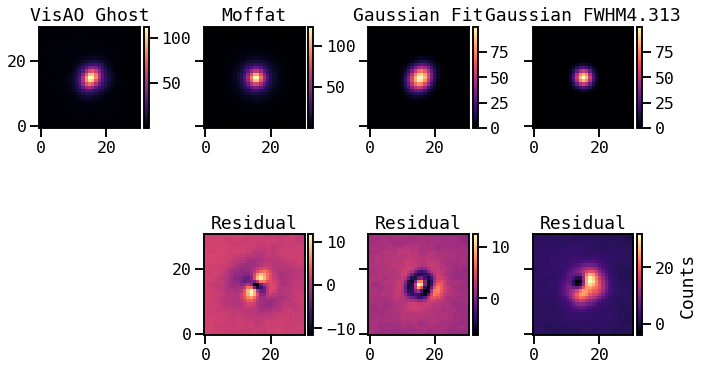

In [9]:
# again can mostly ignore this cell, just run it and it will only loop once but will 
# create the FM and store it as a variable

multipleGs = None#[fwhm,4.5,4,3.5]
    
# only need to do this once for each wavel
ghosts = []
moffs = []
gaussfits = []
gaussfwhms = []

if multipleGs is not None:
    gaussfwhms_list = []
    for fwhm in multipleGs:
        gaussfwhms = []
        for i in range(len(filepaths)):
            filepath = filepaths[i]
            outputdir = outputdirs[i]
            ghostdata, moffat, gaussfit, gaussfwhm, fwhm = ghost.ghostIsolation(filepath, 380, 220, 10, fwhm, 1, fwhm=fwhm)
            gaussfwhms.append(gaussfwhm)
            
        gaussfwhms_list.append(gaussfwhms)
        
else:
    for i in range(len(filepaths)):
        filepath = filepaths[i]
        outputdir = outputdirs[i]
        ghostdata, moffat, gaussfit, gaussfwhm, fwhm, smof = ghost.ghostIsolation(filepath, 380, 220, 10, fwhm, 1, fwhm=fwhm)
        try:
            plt.savefig(outputdir+'/'+'FM-psfs.png', dpi=300)
        except FileNotFoundError:
            os.makedirs(outputdir+'/')
            plt.savefig(outputdir+'/'+'FM-psfs.png', dpi=300)
        ghosts.append(ghostdata)
        moffs.append(smof)#moffat)
        gaussfits.append(gaussfit)
        gaussfwhms.append(gaussfwhm)

doGaussian
m3a[120, 140]KL100mnumba100
reading data, num files:  2637
Parameters set, ready to begin forward modeling... 
saving files to: .\output/HD100453/17Feb17/Cont_10
instrumental PSF FWHM is: 4.313
fm_class ready for KLIP
Begin align and scale images for each wavelength
Align and scale finished
Starting KLIP for sector 1/1 with an area of 16336.281798666923 pix^2
Time spent on last sector: 0s
Time spent since beginning: 0s
First sector: Can't predict remaining time
 100.00% of sector, 100.00% of total completed
Closing threadpool
Writing KLIPed Images to directory /Users/wbalmer/diskShapers/forwardModel/output/HD100453/17Feb17/Cont_10
Done constructing forward model! You are ready to MCMC.
output/HD100453/17Feb17/Cont_10/doGaussian/Cont_104.313
smoothing!
Running burn in
Burn in finished. Now sampling posterior
MCMC sampler has finished
time taken:  21.0  seconds
Raw X/Y Centroid = (95.05582647928156, -88.68620226203694) with statistical error of [-0.04343819  0.10122061] pix in

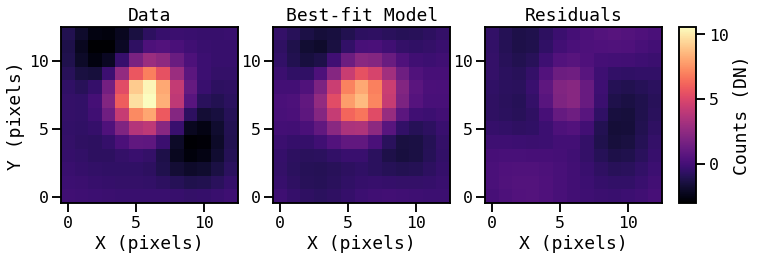

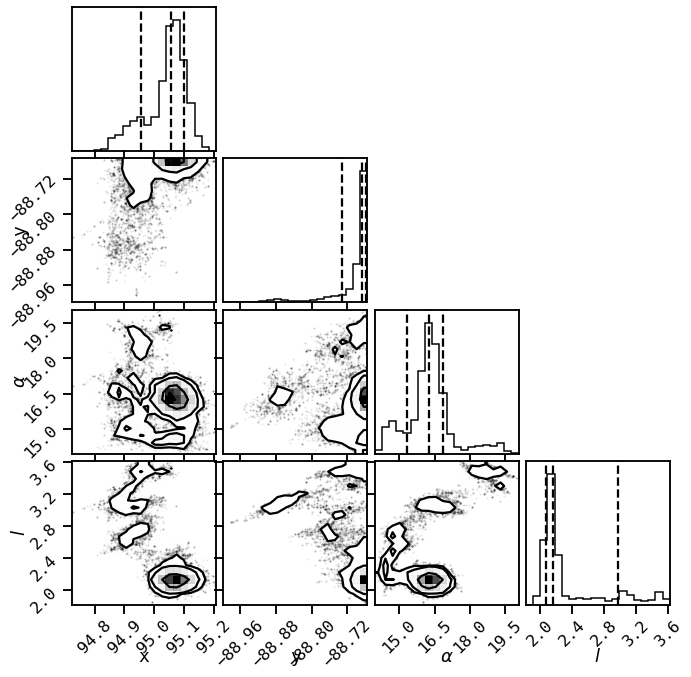

created PE module
generated FM \& data stamps
set kernel
set bounds
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -21.205887253783182      +/-  0.21128038031215213     
 Total Likelihood Evaluations:        18478
 Sampling finished. Exiting MultiNest
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    3
 *****************************************************
 ln(ev)=  -2670.6345769695372      +/-  0.11707796950431282     
  analysing data from output/HD100453/17Feb17/Cont_10/doGaussian/Cont_104.313Planet-.txt Total Likelihood Evaluations:         4794
 Sampling finished. Exiting MultiNest

  analysing data from output/HD100453/17Feb17/Cont_10/doGaussian/Cont_104.313Null

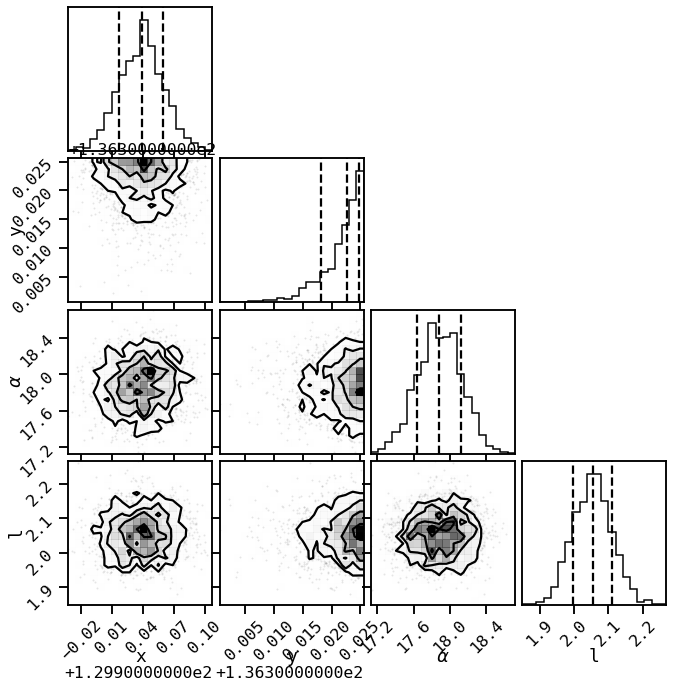

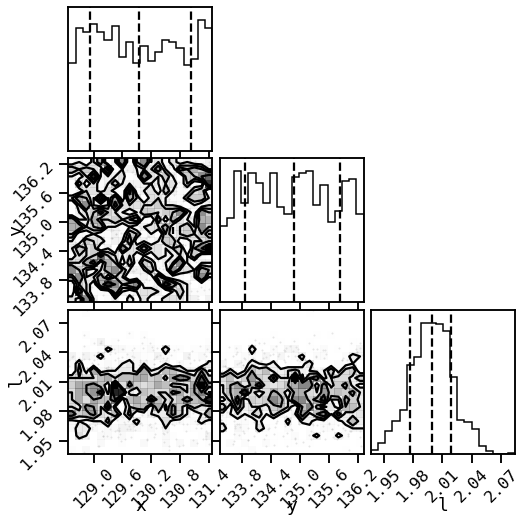

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

evidence ratio is:  inf  >5 is strong evidence
SNR from data stamp residuals: 15.24537478840196


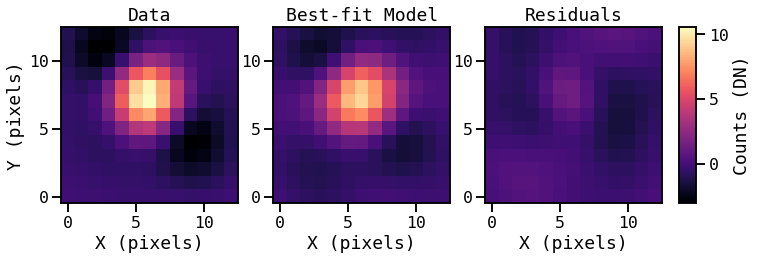

In [13]:
# another vestigial loop
if multipleGs is not None:
    psfplans = []
    for i in range(len(multipleGs)):
        fwhm = multipleGs[i]
        psfs = gaussfwhms_list[i]
        plan = ['doGs',fwhm,psfs]
        psfplans.append(plan)

# this is the real running of the code, wrapped in another vestigial loop
residuals = []
for instpsf in psfplans:
    PSFpath = instpsf[0]
    print(PSFpath)
    if PSFpath == 'doGaussian':
        outside_psfs = gaussfwhms
        FWHM = fwhm
    if PSFpath == 'doGs':
        outside_psfs = instpsf[2]
        PSFpath = 'doGaussian'
        FWHM = fwhm
    elif PSFpath == 'doGaussFit':
        outside_psfs = gaussfits
        FWHM = instpsf[1]
    elif PSFpath == 'doMoffat':
        outside_psfs = moffs
        FWHM = instpsf[1]
    elif PSFpath == 'doGhost':
        outside_psfs = ghosts
        FWHM = instpsf[1]
    
    # ---- you can ignore up to here ----

    # run
    for i in range(len(filepaths)):
        filepath = filepaths[i]
        outputdir = outputdirs[i]
        prefix = prefixes[i]
        outside_psf = outside_psfs[i]
        # this step sets all the parameters for the klip reduction
        fm = forwardModel(filepath, outputdir, prefix, KLmode, sep, pa, contrast, an, move, scale, ePSF=PSFpath, FWHM=FWHM, cores=cores, highpass=highpass, numbasis=numbasis, outside_psf=outside_psf)
        fm.prep_KLIP() # important step
        fm.run_KLIP() # important step

        
        # you might run into trouble here, since again this is my own file strcutre
        # you can always hardcode these paths
        # if you do that, just hardcode them at the "fm_frame" and "data_frame" variables below
        # to point to the klip output files that have "-fmpsf-KLmodes-all.fits" extention (the FM)
        # and "-klipped-KLmodes-all.fits" (the post-klip img)
        
        output_prefix = outputdir+'/'
        # move image
        try:
            from shutil import move, copy
            src = output_prefix + prefix + "-fmpsf-KLmodes-all.fits"
            dest = src.replace(prefix + "-fmpsf-KLmodes-all.fits", PSFpath+'/'+prefix+str(FWHM)+'-fmpsf-KLmodes-all.fits')
            try:
                move(src, dest)
            except OSError:
                copy(src, dest)
            src = output_prefix + prefix + "-klipped-KLmodes-all.fits"
            dest = src.replace(prefix + "-klipped-KLmodes-all.fits", PSFpath+'/'+prefix+str(FWHM)+'-klipped-KLmodes-all.fits')
            move(src, dest)
        except FileNotFoundError:
            src = output_prefix + prefix + "-fmpsf-KLmodes-all.fits"
            os.mkdir(src.replace(prefix + "-fmpsf-KLmodes-all.fits", '/'+PSFpath+'/'))
            dest = src.replace(prefix + "-fmpsf-KLmodes-all.fits", PSFpath+'/'+prefix+str(FWHM)+'-fmpsf-KLmodes-all.fits')
            os.rename(src, dest)
            src = output_prefix + prefix + "-klipped-KLmodes-all.fits"
            dest = src.replace(prefix + "-klipped-KLmodes-all.fits", PSFpath+'/'+prefix+str(FWHM)+'-klipped-KLmodes-all.fits')
            os.rename(src, dest)
        output_prefix_orig = output_prefix
        output_prefix = os.path.join(output_prefix, PSFpath)
        output_prefix = output_prefix+'/'+prefix+str(FWHM)
        print(output_prefix)
        
        length = 2.5  # guess here also

        # set some boundaries for your MCMC
        x_range = 1.5  # in pixels, anywhere from 1.5-5 is reasonable
        y_range = 1.5  # same as x
        flux_range = [5,500] # flux can vary by an order of magnitude
        corr_len_range = 2.5  # between 0.3 and 30

        # output to save chain to
        pklout = outputdir+'/'+prefix+PSFpath.replace('do', '')+str(FWHM)+'_chain.pkl'

        # get FM frame
        fm_frame = fits.getdata(output_prefix + "-fmpsf-KLmodes-all.fits")[0]
        fm_header = fits.getheader(output_prefix + "-fmpsf-KLmodes-all.fits")
        if smooth:
            print('smoothing!')
            fm_frame = nan_gaussian_filter(fm_frame, smooth)
        fm_centx = fm_header['PSFCENTX']
        fm_centy = fm_header['PSFCENTY']

        # get data_stamp frame
        data_frame = fits.getdata(output_prefix + "-klipped-KLmodes-all.fits")[0]
        if outputiwa is not None:
            data_frame = domask(data_frame, inn=outputiwa, outt=451)
        data_header = fits.getheader(output_prefix + "-klipped-KLmodes-all.fits")
        if smooth:
            data_frame = nan_gaussian_filter(data_frame, smooth)
        data_centx = data_header['PSFCENTX']
        data_centy = data_header['PSFCENTY']

        # and finally some parameters for the MCMC run
        nwalkers = 8

        nburn = 500
        nsteps = 2500

        # get initial guesses. Should be in the header but aren't?
        guesssep = sep
        guesspa = pa

        # create FM Astrometry object - 13 is fitboxsize
        fma = fitpsf.FMAstrometry(guesssep, guesspa, 13)

        # generate FM stamp
        # padding should be greater than 0 so we don't run into interpolation problems
        fma.generate_fm_stamp(fm_frame, [fm_centx, fm_centy], padding=5)

        # generate data_stamp stamp
        # note that dr=4 means we are using a 4 pixel wide annulus to sample the noise for each pixel
        # exclusion_radius excludes all pixels less than that distance from the estimated location of the planet
        fma.generate_data_stamp(data_frame, [data_centx, data_centy], dr=4, exclusion_radius=3)

        # set kernel, no read noise
        corr_len_guess = length
        corr_len_label = r"$l$"
        fma.set_kernel("matern32", [corr_len_guess], [corr_len_label])

        # set bounds based on given boundaries
        fma.set_bounds(x_range, y_range, flux_range, [corr_len_range])

        t0 = time.time()

        # ------ MCMC fit ------
        # if you just want to use the nested sampler, comment out these next lines:
        fma.fit_astrometry(nwalkers=nwalkers, nburn=nburn, nsteps=nsteps, numthreads=cores, chain_output=pklout)

        t1 = time.time()
        print("time taken: ", str(np.round(t1-t0)), " seconds")

        fma.propogate_errs(star_center_err=0.1, platescale=platescale, platescale_err=platescale_err, pa_offset=pa_offset, pa_uncertainty=pa_uncertainty)
        # And third is the model comparison and residuals
        fig = fma.best_fit_and_residuals()
        plt.savefig(output_prefix+'_BKA_residuals'+PSFpath.replace('do',str(FWHM))+'.png', transparent=True, dpi=300)
        plt.show()
        fig = fma.make_corner_plot()
        plt.savefig(output_prefix+'_BKA_corner'+PSFpath.replace('do',str(FWHM))+'.png', transparent=True, dpi=300)
        plt.show()
        
        # ----- MCMC --------
        
        # create Planet Evidence Module
        global fit
        fit = fitpsf.PlanetEvidence(sep, pa, 13, output_prefix)
        print('created PE module')
        
        # generate FM stamp
        # padding should be greater than 0 so we don't run into interpolation problems
        fit.generate_fm_stamp(fm_frame, [fm_centx, fm_centy], padding=5)

        # generate data_stamp stamp
        # not that dr=4 means we are using a 4 pixel wide annulus to sample the noise for each pixel
        # exclusion_radius excludes all pixels less than that distance from the estimated location of the planet
        fit.generate_data_stamp(data_frame, [data_centx, data_centy], dr=3, exclusion_radius=5)
        print('generated FM \& data stamps')
        # set kernel, no read noise
        corr_len_guess = 3.
        corr_len_label = r"$l$"
        fit.set_kernel("matern32", [corr_len_guess], [corr_len_label])
        print('set kernel')
        fit.set_bounds(x_range, y_range, flux_range, [corr_len_range])
        print('set bounds')
        
        #Run the pymultinest fit
        # if you just want to run the mcmc, comment out everything below this line:
        # ----- nested -----
        
        fit.multifit()
        print('ran fit')
        global corn, nullcorn
        
        
        corn, nullcorn = fit.fit_plots()
        plt.show()
        corn
        plt.savefig(output_prefix+'_evidence_corner'+PSFpath.replace('do',str(FWHM))+'.png', transparent=True, dpi=300)
        plt.show()
        nullcorn
        plt.savefig(output_prefix+'_null_corner'+PSFpath.replace('do',str(FWHM))+'.png', transparent=True, dpi=300)
        plt.show()
        
        evidence = fit.fit_stats()
        
        #Forward model evidence
        fm_evidence = evidence[0]['nested sampling global log-evidence']
        #forward model parameter distributions, containing the median and percentiles for each
        fm_posteriors = evidence[0]['marginals']

        #Null model evidence
        null_evidence = evidence[1]['nested sampling global log-evidence']
        #null parameter distributions, containing the median and percentiles for each
        null_posteriors = evidence[1]['marginals']
        global evidence_ratio
        evidence_ratio = np.exp(fm_evidence)/np.exp(null_evidence)
        
        print('evidence ratio is: ',round(np.log(evidence_ratio), 4),' >5 is strong evidence')
        global snr
        residnfig, snr = fit.fm_residuals()
        residContg = residnfig
        residnfig
        plt.savefig(output_prefix+'_BKA_residuals'+PSFpath.replace('do',str(FWHM))+'.png', transparent=True, dpi=300)
        # ----- nested -----

# pull in saved data & get final fm info

In [14]:
print(np.log(evidence_ratio))
print(snr)
print(params)

inf
15.24537478840196
m3a[120, 140]KL100mnumba100


In [15]:
import glob
nights = glob.glob('output/'+date+'/')
# psfs = ['Ghost', 'Moffat','Gaussian']
psfs = ['Gaussian']
for night in nights:
    pikls = []
    for psf in psfs:
        pikl = glob.glob(night+prefixes[0]+'/*'+psf+'*.pkl')
        for peesef in pikl:
            pikls.append(peesef)
    print(pikls)
    
# We load in the results of the MCMC from the compressed pickle file
# the pyklip code has generated for us
import pandas as pd
chains = []
for pklout in pikls:
    print(pklout)
    chain = pickle.load(open(pklout, "rb"))
    chains.append(chain)
    print(chain.shape)
chain_info_ra = chains[0][:,:,0].ravel()
chain_info_dec = chains[0][:,:,1].ravel()
chain_info_alpha = chains[0][:,:,2].ravel()
chain_info_l = chains[0][:,:,3].ravel()
for chain in chains[1:]:
    chain_info_ra = np.append(chain[:,:,0].ravel(), chain_info_ra)
    chain_info_dec = np.append(chain[:,:,1].ravel(), chain_info_dec)
    chain_info_alpha = np.append(chain[:,:,2].ravel(), chain_info_alpha)
    chain_info_l = np.append(chain[:,:,3].ravel(), chain_info_l)

post = pd.DataFrame(columns=['ra', 'dec', 'alpha', 'l'])
post['ra'] = chain_info_ra-225
post['dec'] = chain_info_dec-225
post['alpha'] = chain_info_alpha
post['l'] = chain_info_l

class ParamRange(object):
    """
    Stores the best fit value and uncertainities for a parameter in a neat fasion

    Args:
        bestfit (float): the bestfit value
        err_range: either a float or a 2-element tuple (+val1, -val2) and gives the 1-sigma range

    Attributes:
        bestfit (float): the bestfit value
        error (float): the average 1-sigma error
        error_2sided (np.array): [+error1, -error2] 2-element array with asymmetric errors
    """
    def __init__(self, bestfit, err_range):
        self.bestfit = bestfit

        if isinstance(err_range, (int, float)):
            self.error = err_range
            self.error_2sided = np.array([err_range, -err_range])
        elif len(err_range) == 2:
            self.error_2sided = np.array(err_range)
            self.error = np.mean(np.abs(err_range))
            
import astropy.stats.circstats as circstats
x_fit = post['ra'].to_numpy()
y_fit = post['dec'].to_numpy()
x_best = np.median(post['ra'])
y_best = np.median(post['dec'])
x_1sigma_raw = np.percentile(post['ra'], [84,16]) - np.median(post['ra'])
y_1sigma_raw = np.percentile(post['dec'], [84,16]) - np.median(post['dec'])

# print("Raw X/Y Centroid = ({0}, {1}) with statistical error of {2} pix in X and {3} pix in Y".format(x_best, y_best, x_1sigma_raw, y_1sigma_raw))

# calculate sep and pa from x/y separation
sep_fit = np.sqrt((x_fit)**2 + (y_fit)**2)
# For PA compute mean using circstats package, find delta_pa between all points and the mean,
# then compute median/precentiles
pa_fit = (np.arctan2(y_fit, x_fit) - (np.pi/2.0)) % (2.0*np.pi) # Radians!
# for Bayesian, convert the chains to sep/pa to get uncertainity
pa_mean = circstats.circmean(pa_fit - np.pi) + np.pi # Circmean [-pi, pi]
d_pa = np.arctan2(np.sin(pa_fit-pa_mean), np.cos(pa_fit-pa_mean))
pa_median = np.median(d_pa) + pa_mean
pa_percentile = np.nanpercentile(d_pa, [84,16])  - np.median(d_pa) # median of d_pa should be small
pa_fit = np.degrees(pa_fit) # Convert to degrees

# calculate sep and pa statistical errors
sep_best = np.median(sep_fit)
pa_best = np.degrees(pa_median)
sep_1sigma_raw = (np.percentile(sep_fit, [84,16]) - sep_best)
pa_1sigma_raw = np.degrees(pa_percentile)

# print("Raw Sep/PA Centroid = ({0}, {1}) with statistical error of {2} pix in Sep and {3} pix in PA".format(sep_best, pa_best, sep_1sigma_raw, pa_1sigma_raw))

# store the raw sep and PA values
raw_sep = ParamRange(sep_best, sep_1sigma_raw)
raw_PA = ParamRange(pa_best, pa_1sigma_raw)

star_center_err = 0.1

sep_err_pix = (sep_1sigma_raw**2) + star_center_err**2
sep_err_pix = np.sqrt(sep_err_pix)

sep_err_mas = np.sqrt((sep_err_pix * platescale)**2 + (platescale_err * sep_best)**2)

pa_fit = np.radians((pa_fit + pa_offset) % 360) # Convert back to radians for circstats
pa_mean = circstats.circmean(pa_fit - np.pi) + np.pi # Circmean [-pi, pi]
d_pa = np.arctan2(np.sin(pa_fit-pa_mean), np.cos(pa_fit-pa_mean))

pa_median = np.median(d_pa) + pa_mean
pa_best = np.degrees(pa_median)

pa_fit = np.degrees(pa_fit) # Convert back to degrees

pa_err = np.radians(pa_1sigma_raw)**2 + (star_center_err/sep_best)**2 + np.radians(pa_uncertainty)**2
pa_err = np.sqrt(pa_err)
pa_err_deg = np.degrees(pa_err)

sep_err_pix_avg = np.mean(np.abs(sep_err_pix))
pa_err_deg_avg = np.mean(np.abs(pa_err_deg))

# print("Sep = {0} +/- {1} ({2}) pix, PA = {3} +/- {4} ({5}) degrees".format(sep_best, sep_err_pix_avg, sep_err_pix, pa_best, pa_err_deg_avg, pa_err_deg))

sep = ParamRange(sep_best, sep_err_pix)
PA = ParamRange(pa_best, pa_err_deg)

sep_err_mas_avg = np.mean(np.abs(sep_err_mas))
# print("Sep = {0} +/- {1} ({2}) mas, PA = {3} +/- {4} ({5}) degrees".format(sep_best*platescale, sep_err_mas_avg, sep_err_mas, pa_best, pa_err_deg_avg, pa_err_deg))
# overwrite sep values with values converted to milliarcseconds
sep = ParamRange(sep_best*platescale, sep_err_mas)

result = pd.DataFrame(index=[date])
result['sep'] = [sep.bestfit]
result['seperr'] = [sep.error]
result['sepweight'] = [1/sep.error**2]
result['pa'] = [PA.bestfit]
result['paerr'] = [PA.error]
result['paweight'] = [1/PA.error**2]
result['alpha'] = [np.nanmedian(post['alpha'])]
result['alphaerr'] = [np.nanstd(post['alpha'])]
result['log evidence_ratio'] = np.log(evidence_ratio)
result['SNR'] = snr
result['params'] = params
result

['output/HD100453/17Feb17/Cont_10/Cont_10Gaussian4.313_chain.pkl']
output/HD100453/17Feb17/Cont_10/Cont_10Gaussian4.313_chain.pkl
(8, 2500, 4)


,sep,seperr,sepweight,pa,paerr,paweight,alpha,alphaerr,log evidence_ratio,SNR,params
HD100453/17Feb17,1033.549746,13.027876,0.005892,132.517666,0.199915,25.021351,16.282954,1.018285,inf,15.245375,"m3a[120, 140]KL100mnumba100"


In [20]:
result.to_clipboard(header=False)

# SDI image

In [17]:
# scalefactordict = {'11Apr13':0.98,'8Apr14':1.19,'8Apr14_long':0.88,
#                    '15May15':1.16, '16May15':1.18, '18May15':1.22,
#                    '10Feb17':1.82, '27Apr18':1.22}

In [18]:
# if 'Cont' in output_prefix_orig:
#     cont = fits.getdata(glob.glob(output_prefix_orig+'/doGaussian/*-klipped*.fits')[0])[0]
#     line = fits.getdata(glob.glob(output_prefix_orig.replace('Cont', 'Ha')+'/doGaussian/*-klipped*.fits')[0])[0]
# elif 'Ha' in output_prefix_orig:
#     line = fits.getdata(glob.glob(output_prefix_orig+'/doGaussian/*-klipped*.fits')[0])[0]
#     cont = fits.getdata(glob.glob(output_prefix_orig.replace('Ha', 'Cont')+'/doGaussian/*-klipped*.fits')[0])[0]
    
# inner = 3
# x1,x2 = 215,235
# y1,y2 = 215,235
# smooth = 1

# # make residual map
# residual_map = (line)-(cont*scale)

# line = create_map(line, fwhm, planets=planetData, saveOutput=False, outputName='test')[0][0][0]
# cont = create_map(cont, fwhm, planets=planetData, saveOutput=False, outputName='test')[0][0][0]
# residual_map = create_map(residual_map, fwhm, planets=planetData, saveOutput=False, outputName='test')[0][0][0]

# if smooth is not None:
#     line = domask(nan_gaussian_filter(line, smooth), inn=inner)
#     cont = domask(nan_gaussian_filter(cont, smooth), inn=inner)
#     residual_map = domask(nan_gaussian_filter(residual_map, smooth), inn=inner)

# line[np.isnan(line)] = np.nanmedian(line)
# cont[np.isnan(cont)] = np.nanmedian(cont)
# residual_map[np.isnan(residual_map)] = np.nanmedian(residual_map)

# scale = 1#scalefactordict[date]

# n2 = line.max()

# import matplotlib
# import matplotlib.pylab as plt
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# from astropy.visualization import LogStretch, SinhStretch
# from astropy.visualization.mpl_normalize import ImageNormalize

# fig = plt.figure(figsize=(12, 4))



# # normalize all images to same scale
# colornorm = matplotlib.colors.Normalize(vmin=np.nanpercentile(line, 0.03),
#                                         vmax=np.nanpercentile(line, 99.7))

# colornorm = ImageNormalize(stretch=SinhStretch(), vmax=line.max())

# # plot the data_stamp
# ax1 = fig.add_subplot(131)
# im1 = ax1.imshow(line, cmap='magma')#, norm=colornorm)
# ax1.invert_yaxis()
# ax1.set_title(r"H$\alpha$, $\lambda=0.656$")
# ax1.set_xlabel("X (pixels)")
# ax1.set_ylabel("Y (pixels)")
# ax1.set_xlim(x1,x2)
# ax1.set_ylim(y1,y2)
# divider = make_axes_locatable(ax1)
# cax1 = divider.append_axes("right", size="5%", pad=0.05)
# cb1 = fig.colorbar(im1, cax=cax1)#, ticks=[-500, 0, 500])

# ax2 = fig.add_subplot(132)
# im2 = ax2.imshow(cont, cmap='magma')#, norm=colornorm)
# ax2.invert_yaxis()
# ax2.set(yticklabels=[])
# ax2.set_title(r"Continuum, $\lambda=0.658$")
# ax2.set_xlabel("X (pixels)")
# ax2.set_xlim(x1,x2)
# ax2.set_ylim(y1,y2)
# divider = make_axes_locatable(ax2)
# cax2 = divider.append_axes("right", size="5%", pad=0.05)
# cb2 = fig.colorbar(im1, cax=cax2)#, ticks=[-500, 0, 500])

# ax3 = fig.add_subplot(133)
# im3 = ax3.imshow(residual_map, cmap='magma')#, norm=colornorm)#, vmin=-n2, vmax=n2)
# ax3.invert_yaxis()
# ax3.set(yticklabels=[])
# ax3.set_title(r"SDI (H$\alpha$ - Cont)")
# ax3.set_xlabel("X (pixels)")
# ax3.set_xlim(x1,x2)
# ax3.set_ylim(y1,y2)

# divider = make_axes_locatable(ax3)
# cax3 = divider.append_axes("right", size="5%", pad=0.05)
# cb3 = fig.colorbar(im3, cax=cax3)#, ticks=[-n2, 0, n2])
# cb3.set_label("SNR")

# plt.savefig(outputdir+'/SDI'+PSFpath.replace('do',str(FWHM))+'.png', transparent=True, dpi=300)